<a href="https://colab.research.google.com/github/anama-1104/cis677/blob/main/Fall2025_skeleton_project3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 3
This is is a starting point for project 3.

The purpose of project 3 is to use the NUMBA/CUDA environment to program an NVIDIA GPU.

You will write a slightly more complicated version of something that can be done easily and concisely using matplotlib: Plotting a function.

The execution environment needs some special setups:

In [5]:
import os
os.environ['NUMBAPRO_LIBDEVICE'] = "/usr/local/cuda-12.5/nvvm/libdevice"
os.environ['NUMBAPRO_NVVM'] = "/usr/local/cuda-12.5/nvvm/lib64/libnvvm.so"

In [6]:
!uv pip install -q --system numba-cuda==0.4.0

In [7]:
from numba import config
config.CUDA_ENABLE_PYNVJITLINK = 1

Let's check the characteristics of the GPU:

In [8]:
from numba import cuda

def list_cuda_devices():
    try:
        # Get the number of available CUDA devices
        device_count = cuda.list_devices()

        # Print the number of available CUDA devices
        print(f"Number of CUDA devices available: {len(device_count)}")
        device = cuda.get_current_device()
        print(f"\nDevice  {device.name}")
        print(f"  Compute Capability: {device.compute_capability}")
        print(f"  Multiprocessors: {device.MULTIPROCESSOR_COUNT}")
        print(f"  Max Threads per Block: {device.MAX_THREADS_PER_BLOCK}")
        print(f"  Max Block Dimensions: {device.MAX_BLOCK_DIM_X}, {device.MAX_BLOCK_DIM_Y}, {device.MAX_BLOCK_DIM_Z}")
        print(f"  Max Grid Dimensions: {device.MAX_GRID_DIM_X}, {device.MAX_GRID_DIM_Y}, {device.MAX_GRID_DIM_Z}")
    except cuda.CudaSupportError as e:
        print("CUDA is not supported or no devices are available.")
        print(f"Error: {e}")



if __name__ == "__main__":
    list_cuda_devices()


Number of CUDA devices available: 1

Device  b'Tesla T4'
  Compute Capability: (7, 5)
  Multiprocessors: 40
  Max Threads per Block: 1024
  Max Block Dimensions: 1024, 1024, 64
  Max Grid Dimensions: 2147483647, 65535, 65535


## A most reasonable way to plot a function

This is a very reasonable way of plotting a polynomial in a specific range.

The polynomial is $y = x^4 - 10 x^2 + 9$.

This polynomial has 4 roots at: ${-3,-1,1,3}$



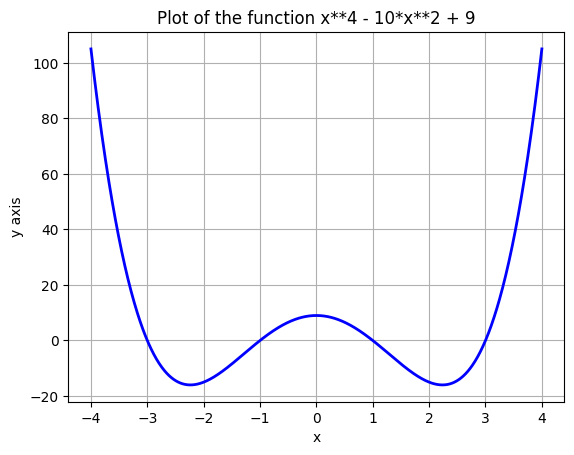

In [9]:
import numpy as np
import matplotlib.pyplot as plt

def f(x):
    return x**4 - 10*x**2 + 9

x = np.linspace(-4,4,1000)

plt.plot(x,f(x),color="blue", linewidth=2)
plt.title("Plot of the function x**4 - 10*x**2 + 9")
plt.xlabel("x")
plt.ylabel("y axis")
plt.grid(True)
plt.show()

We can write a slightly different version that uses a second array y to hold the value associated with every value in the array x:

The values on the X axis are incorrect. We'll ignore this.

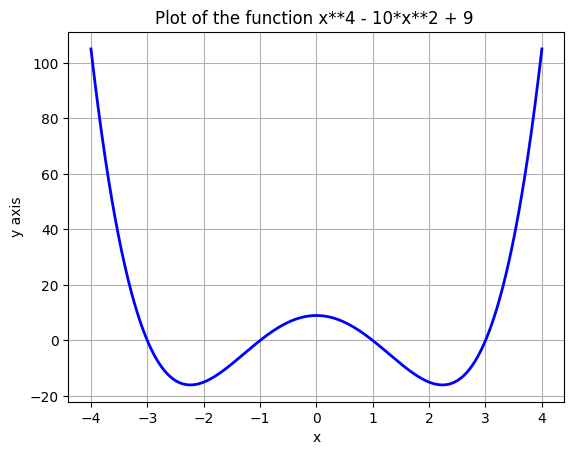

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def f(x):
    return x**4 - 10*x**2 + 9

x = np.linspace(-4,4,1000)
y = np.asarray(x)

y = f(x)

plt.plot(x,y,color="blue", linewidth=2)
plt.title("Plot of the function x**4 - 10*x**2 + 9 ")
plt.xlabel("x")
plt.ylabel("y axis")
plt.grid(True)
plt.show()

Your job is to translate this code into python code that uses NUMBA/CUDA to perform the calculation of the y array on the GPU.

This will require:

1. Importing the numba cuda library (from numba import cuda, float32)
2. Rewrite the function that calculates the value of y so that it becomes a kernel to be executed on the GPU:
  a. Use the @cuda.jit decorator at the beginning of the function
  b. Use two arguments for the function x and y
  c. Use the grid(1) function to obtain the index on the arrays
  d. Write the following code:

    if i < y.shape[0]:

        y[i] = x[i]**4 - 10*x[i]**2 + 9
3. In the main code:
   After the creation of the x and y arrays
   Create two new arrays that will be allocated on the GPU, using the to_device funtion from numba cuda:
    x_device = cuda.to_device(x)
    y_device = cuda.to_device(y)

4. Invoke the kernel with appropriate values for the grid size and the block size.

5. Copy the y_device array back to the host:
   y = y_device.copy_to_host()

Generate the plot.



Your code goes here:

CUDA available? -> True


/usr/local/lib/python3.12/dist-packages/numba_cuda/numba/cuda/dispatcher.py:680: NumbaPerformanceWarning: Grid size 4 will likely result in GPU under-utilization due to low occupancy.
  def _numba_type_(self):


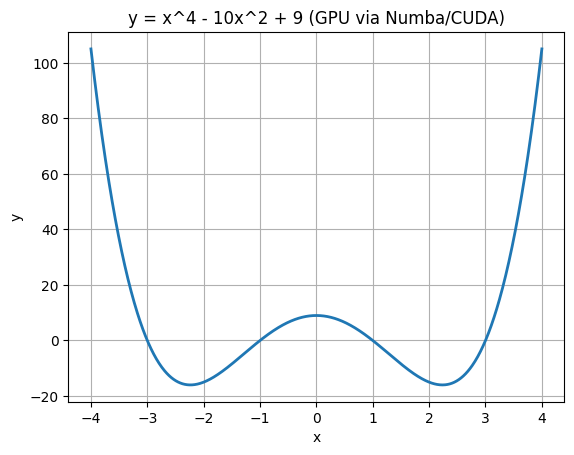

In [14]:
import numpy as np
import matplotlib.pyplot as plt

from numba import cuda, float32

print("CUDA available? ->", cuda.is_available())


@cuda.jit
def calculate_y_kernel(x, y):
    """
    A CUDA kernel to calculate y = x**4 - 10*x**2 + 9 on the GPU.
    """

    i = cuda.grid(1)


    if i < y.shape[0]:
        xi = x[i]
        x2 = xi * xi
        y[i] = (x2 * x2) - 10.0 * x2 + 9.0


n = 1000


x = np.linspace(-4, 4, n, dtype=np.float32)
y = np.zeros(n, dtype=np.float32)

x_device = cuda.to_device(x)
y_device = cuda.to_device(y)


threads_per_block = 256
blocks_per_grid = (n + threads_per_block - 1) // threads_per_block

calculate_y_kernel[blocks_per_grid, threads_per_block](x_device, y_device)
cuda.synchronize()

y = y_device.copy_to_host()

plt.plot(x, y, linewidth=2)
plt.title("y = x^4 - 10x^2 + 9 (GPU via Numba/CUDA)")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.show()